In [ ]:
!git clone https://github.com/ao9000/sc4002_g24

Cloning into 'sc4002_g24'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')


Found GPU at: /device:GPU:0


In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pickle

In [4]:
%pip  install torch datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00


In [ ]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
df = pd.read_csv("/content/drive/MyDrive/augmented_combined_train_dataset.csv")
df['text'] = df['text'].astype(str)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split



model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])



from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Then specify this data_collator in your Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=64,  # Adjust based on GPU memory
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.365530,0.831144,0.835395,0.831144,0.830608
2,No log,0.428663,0.841463,0.843496,0.841463,0.841229
3,No log,0.449511,0.853659,0.854502,0.853659,0.853571
4,0.255300,0.537023,0.850844,0.850944,0.850844,0.850834
5,0.255300,0.654303,0.850844,0.850846,0.850844,0.850844


TrainOutput(global_step=670, training_loss=0.20775941734883321, metrics={'train_runtime': 306.4979, 'train_samples_per_second': 139.153, 'train_steps_per_second': 2.186, 'total_flos': 882786766824000.0, 'train_loss': 0.20775941734883321, 'epoch': 5.0})

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import torch
from transformers import EarlyStoppingCallback



# 1. Improved data preprocessing
def preprocess_text(text):
    # Add your text cleaning steps here
    text = text.lower()
    text = text.strip()
    # Add more preprocessing steps as needed
    return text

def tokenize_and_encode(batch):
    # Preprocess text first
    texts = [preprocess_text(text) for text in batch["text"]]

    # Tokenize with truncation and padding
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )




# 2. Model initialization with better defaults
model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train_dataset = train_dataset.map(tokenize_and_encode, batched=True)
test_dataset = test_dataset.map(tokenize_and_encode, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    problem_type="single_label_classification",
    attention_probs_dropout_prob=0.2,
    hidden_dropout_prob=0.2
)

# 3. Advanced training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=30,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=2,
    fp16=True,  # If using GPU
    logging_steps=50,
    group_by_length=True,  # Speeds up training by grouping similar lengths
    remove_unused_columns=True,
)

# 4. Enhanced metrics computation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Calculate metrics for each class
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average='weighted'
    )

    # Calculate confusion matrix metrics
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# 5. Custom data collator with dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',
    max_length=512,
    return_tensors="pt"
)

# 6. Initialize trainer with callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=50,
            early_stopping_threshold=0.01
        )
    ],
)

# 7. Train with gradient clipping
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/10348 [00:00<?, ? examples/s]

Map:   0%|          | 0/2587 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 41


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.708800,0.457137,0.798608,0.798601,0.798608,0.798604
200,0.374600,0.346761,0.867414,0.867433,0.867414,0.867394
300,0.320400,0.350341,0.867801,0.869123,0.867801,0.867585
400,0.290100,0.343492,0.877851,0.878172,0.877851,0.877779
500,0.247100,0.334897,0.883649,0.883815,0.883649,0.883605
600,0.226800,0.354750,0.880170,0.881418,0.880170,0.879989
700,0.215400,0.332237,0.887901,0.888397,0.887901,0.887816
800,0.192700,0.359257,0.885195,0.886957,0.885195,0.884973
900,0.186400,0.349151,0.890220,0.891315,0.890220,0.890075
1000,0.179500,0.341651,0.892926,0.893329,0.892926,0.892857


TrainOutput(global_step=1200, training_loss=0.29579184293746946, metrics={'train_runtime': 692.0545, 'train_samples_per_second': 448.577, 'train_steps_per_second': 1.734, 'total_flos': 5312881911788928.0, 'train_loss': 0.29579184293746946, 'epoch': 29.62962962962963})

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import torch
from transformers import EarlyStoppingCallback



# 1. Improved data preprocessing
def preprocess_text(text):
    # Add your text cleaning steps here
    text = text.lower()
    text = text.strip()
    # Add more preprocessing steps as needed
    return text

def tokenize_and_encode(batch):
    # Preprocess text first
    texts = [preprocess_text(text) for text in batch["text"]]

    # Tokenize with truncation and padding
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )




# 2. Model initialization with better defaults
model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train_dataset = train_dataset.map(tokenize_and_encode, batched=True)
test_dataset = test_dataset.map(tokenize_and_encode, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    problem_type="single_label_classification",
    attention_probs_dropout_prob=0.2,
    hidden_dropout_prob=0.2
)

# 3. Advanced training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=30,
    lr_scheduler_type="cosine_with_restarts",  # Add cycling learning rate
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=4,
    fp16=True,  # If using GPU
    logging_steps=50,
    group_by_length=True,  # Speeds up training by grouping similar lengths
    remove_unused_columns=True,
)

# 4. Enhanced metrics computation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Calculate metrics for each class
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average='weighted'
    )

    # Calculate confusion matrix metrics
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# 5. Custom data collator with dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',
    max_length=512,
    return_tensors="pt"
)

# 6. Initialize trainer with callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=50,
            early_stopping_threshold=0.01
        )
    ],
)

# 7. Train with gradient clipping
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/10348 [00:00<?, ? examples/s]

Map:   0%|          | 0/2587 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.394100,0.332558,0.864322,0.864332,0.864322,0.864305
200,0.288800,0.320257,0.882489,0.882545,0.882489,0.882464
300,0.264500,0.322468,0.881716,0.881868,0.881716,0.881673


TrainOutput(global_step=300, training_loss=0.36627187410990397, metrics={'train_runtime': 530.9423, 'train_samples_per_second': 584.696, 'train_steps_per_second': 0.565, 'total_flos': 5281259924891904.0, 'train_loss': 0.36627187410990397, 'epoch': 29.26829268292683})

Accuracy: 0.8968
Precision: 0.8972
Recall: 0.8968
F1-Score: 0.8967


Text(0.5, 1.0, 'Confusion Matrix')

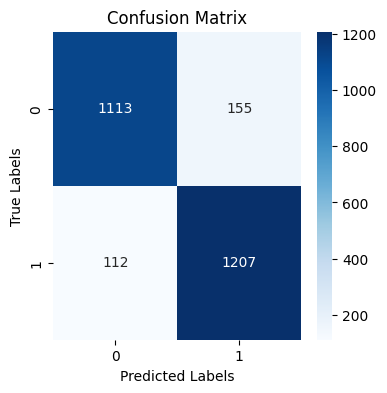

In [13]:

# Making predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')



In [20]:
trainer.save_model("/content/drive/MyDrive/sEX")